In [1]:
### IMPORT LIBRARIES

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize']=(20,20) # graph size

# pandas and statsmodels
import pandas
from statsmodels.stats.weightstats import DescrStatsW

# analog data assimilation
from AnDA_codes.AnDA_generate_data import AnDA_generate_data
from AnDA_codes.AnDA_analog_forecasting import AnDA_analog_forecasting
from AnDA_codes.AnDA_model_forecasting import AnDA_model_forecasting
from AnDA_codes.AnDA_data_assimilation import AnDA_data_assimilation
from AnDA_codes.AnDA_stat_functions import AnDA_RMSE

Populating the interactive namespace from numpy and matplotlib


In [2]:
### IMPORTANT PARAMETERS

# name and date of the tropical cyclone
#TC_name = str("'KATE'" + '_' + "'2003269N12322'")
TC_name = str("'SAM'" + '_' + "'2021262N10349'")

# number of analogs
nb_analogs = 100

# variance of the observations (IBTrACS)
sigma2_obs = 0.05

# variance of the SAR (for Rmax)
#sigma2_sar = 0.01

# index of the first unavailable observation
index_NaN = 60

In [3]:
### GENERATE THE CATALOG, THE TRUE STATE, AND THE OBSERVATIONS

import os
files = os.listdir("AnDA_data/IBTrACS_V2/.")
class catalog:
    IBTrACS_tmp = array(pandas.read_csv("AnDA_data/IBTrACS_V2/" + files[0], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
    analogs = IBTrACS_tmp[0:-1,:]
    successors = IBTrACS_tmp[1:,:]
for i in arange(1, len(files)):
    if files[i] != TC_name:
        IBTrACS_tmp = array(pandas.read_csv("AnDA_data/IBTrACS_V2/" + files[i], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
        catalog.analogs = concatenate([catalog.analogs, IBTrACS_tmp[0:-1,:]])
        catalog.successors = concatenate([catalog.successors, IBTrACS_tmp[1:,:]])
    else:
        class xt:
            time = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv("AnDA_data/IBTrACS_V2/" + files[i], usecols = ['Vmax', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']))
        xt.time = range(shape(IBTrACS_tmp)[0])
        xt.values = IBTrACS_tmp
        class yo:
            time = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv("AnDA_data/IBTrACS_V2/" + files[i], usecols = ['Vmax', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']))
        yo.time = range(shape(IBTrACS_tmp)[0])
        yo.values = IBTrACS_tmp
        #yo.values[index_NaN:,] = NaN
        #yo.values[:,1] = NaN # remove observations of Rmax
        #yo.values[[11, 23, 40, 50, 55], 1] = [12, 10, 21, 23, 24] ### Rmax data from SAR for SAM ###

# center and reduce the 6 columns
mean_IBTrACS = mean(catalog.analogs, axis=0)
std_IBTrACS = std(catalog.analogs, axis=0)
for j in range(shape(catalog.analogs)[1]):
    catalog.analogs[:,j] = (catalog.analogs[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    catalog.successors[:,j] = (catalog.successors[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    xt.values[:,j] = (xt.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    yo.values[:,j] = (yo.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]

In [4]:
### ANALOG DATA ASSIMILATION (dynamical model given by the catalog)

n = shape(xt.values)[1]
p = shape(yo.values)[1]

def get_rmax_ck22_augmented(Vmax, R17, fcor, Ck_Cd):
    '''Computes Rmax using CK22 model with the dependance on Ck_Cd
    INPUT: Vmax (m/s), R17 (m), fcor (s-1), Ck_Cd ()
    OUTPUT: Rmax (m)
    '''
    
    # transform variables
    Vmax = Vmax * std_IBTrACS[0] + mean_IBTrACS[0]
    R17 = (R17 * std_IBTrACS[2] + mean_IBTrACS[2]) * 1000
    fcor = fcor * std_IBTrACS[3] + mean_IBTrACS[3]
    
    # force Ck_Cd to be positive using softplus function
    Ck_Cd = log(1 + exp(Ck_Cd))
    
    # approximate Rmax
    M17      = R17 * 17.5 + 0.5 * fcor * (R17 ** 2)
    Mmax_M17 = (0.5 * Ck_Cd) ** (1 / (2 - Ck_Cd))     # Eq. 38 of ER11. CAVEAT: We must have R17 >> Rmax
    Mmax     = Mmax_M17 * M17
    Rmax     = (Vmax / fcor) * (np.sqrt(1 + (2 * fcor * Mmax) / (Vmax ** 2)) - 1)
    
    return (Rmax / 1000 - mean_IBTrACS[1]) / std_IBTrACS[1] # return Rmax in km

# parameters of the analog forecasting method
class AF:
    k = nb_analogs # number of analogs
    neighborhood = np.ones((n,n)) # global analogs
    neighborhood[:,1] = 0 # do not use Rmax to find analogs ### ??? IMPORTANT ??? ###
    catalog = catalog # catalog with analogs and successors
    regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')
    
# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = 1000 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = r_[xt.values[0,:], 1]; B = np.eye(n+1); B[n,n] = 0.5
    H = delete(np.eye(n+1), [6], axis=0)
    R = sigma2_obs*np.eye(p)
    #R[1,1] = sigma2_sar ### VARIANCE OF THE SAR MEASUREMENTS ###
    @staticmethod
    def m(x):
        x_out = zeros((2, DA.N, n+1))
        # analog forecasting for Vmax, R34, f, U, V
        x_out[:, :, 0:6] = AnDA_analog_forecasting(x[:, 0:6], AF)
        # random walk for Ck/Cd
        x_out[0, :, 6] = 0.999 * x[:, 6] + random.normal(scale = 0.01) ### ??? ADD NOISE ??? ###
        x_out[1, :, 6] = mean(0.999 * x[:, 6] + random.normal(scale = 0.01))
        # Rmax from Vmax, R34, f, Ck/Cd
        x_out[0, :, 1] = get_rmax_ck22_augmented(x_out[0, :, 0], x_out[0, :, 2], x_out[0, :, 3], x_out[0, :, 6])
        x_out[1, :, 1] = mean(get_rmax_ck22_augmented(x_out[0, :, 0], x_out[0, :, 2], x_out[0, :, 3], x_out[0, :, 6]))
        return x_out

# run the analog data assimilation
x_hat_analog = AnDA_data_assimilation(yo, DA)

100%|██████████| 95/95 [00:03<00:00, 26.92it/s]


In [5]:
# compute weighted quantiles
x_hat_analog_quantiles = zeros([shape(x_hat_analog.part)[0], 7, n+1])
for t in range(shape(x_hat_analog.part)[0]):
    for j in range(n+1):
        wq = DescrStatsW(data=x_hat_analog.part[t,:,j], weights=x_hat_analog.weights[t,:])
        x_hat_analog_quantiles[t,:,j] = wq.quantile(probs=np.array([0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]), return_pandas=False)

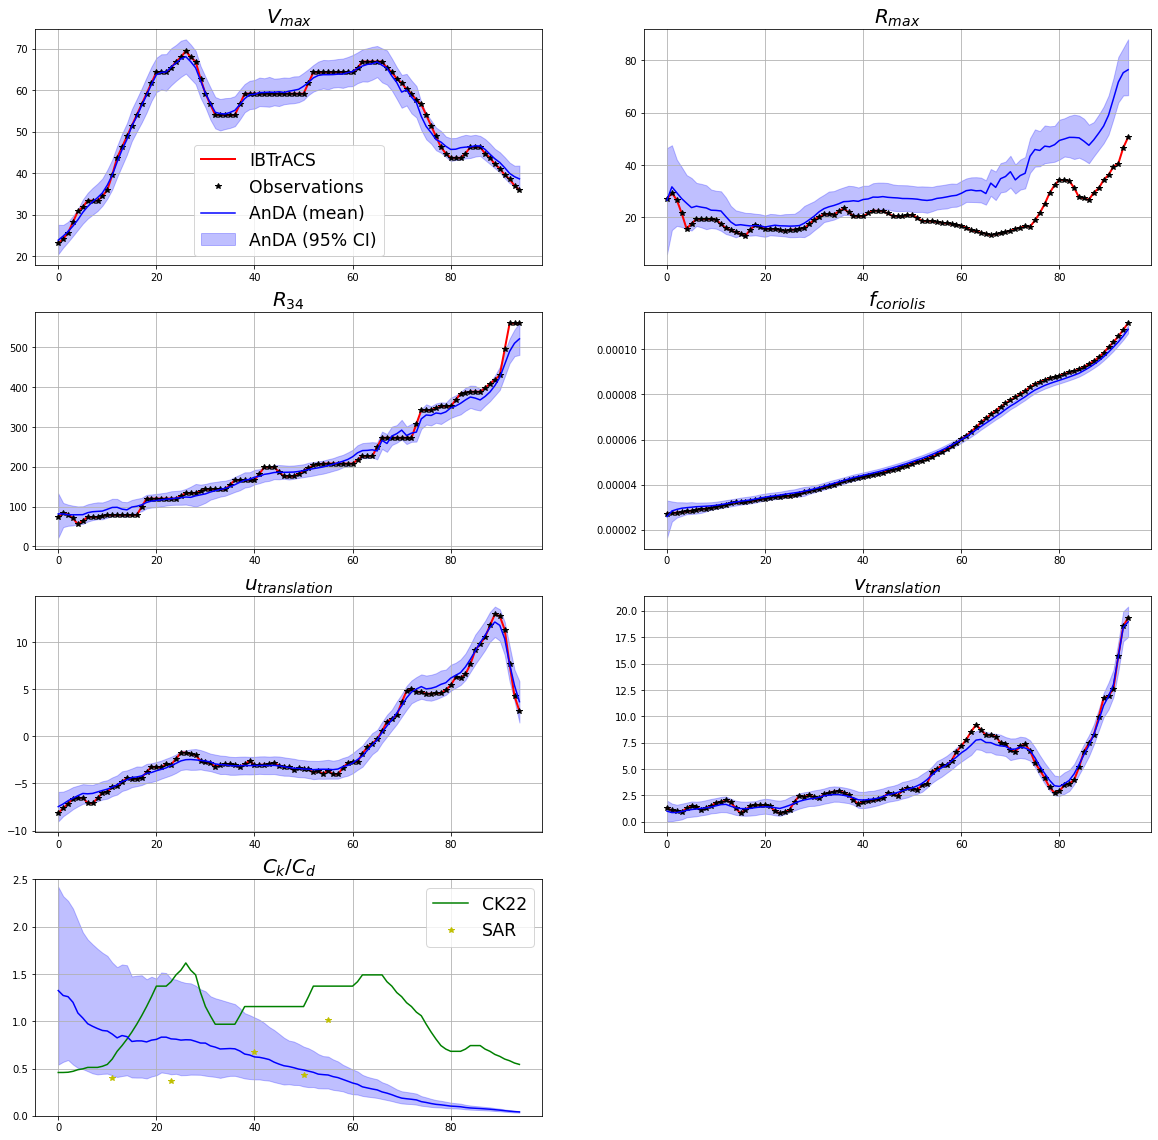

In [6]:
# plot Vmax, Rmax, R34, f, U, V, Ck/Cd
tab_title = ['$V_{max}$', '$R_{max}$', '$R_{34}$', '$f_{coriolis}$', '$u_{translation}$', '$v_{translation}$', '$C_k/C_d$']
for j in range(n+1):
    subplot(4,2,j+1)
    try:
        plot(xt.time, xt.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-r', linewidth=2)
        plot(yo.time, yo.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '*k')
        plot(yo.time, x_hat_analog_quantiles[:,3,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-b')
        fill_between(x_hat_analog.time, x_hat_analog_quantiles[:,0,j] * std_IBTrACS[j] + mean_IBTrACS[j], x_hat_analog_quantiles[:,6,j] * std_IBTrACS[j] + mean_IBTrACS[j], alpha=0.25, color='b')
        grid()
    except:
        plot(yo.time, 0.00055 * (xt.values[:,0] * std_IBTrACS[0] + mean_IBTrACS[0])**2 - 0.0259 * (xt.values[:,0] * std_IBTrACS[0] + mean_IBTrACS[0]) + 0.763, color='g')
        plot([11, 23, 40, 50, 55], [0.4, 0.37, 0.68, 0.43, 1.01], 'y*')
        legend(['CK22', 'SAR'], fontsize='xx-large')
        plot(yo.time, log(1 + exp(x_hat_analog_quantiles[:,3,j])), '-b')
        fill_between(x_hat_analog.time, log(1 + exp(x_hat_analog_quantiles[:,0,j])), log(1 + exp(x_hat_analog_quantiles[:,6,j])), alpha=0.25, color='b')
        ylim([0, 2.5])
        grid()
    title(tab_title[j], size=20)
    if j==0:
        legend(['IBTrACS', 'Observations', 'AnDA (mean)', 'AnDA (95% CI)'], loc=0, fontsize='xx-large')

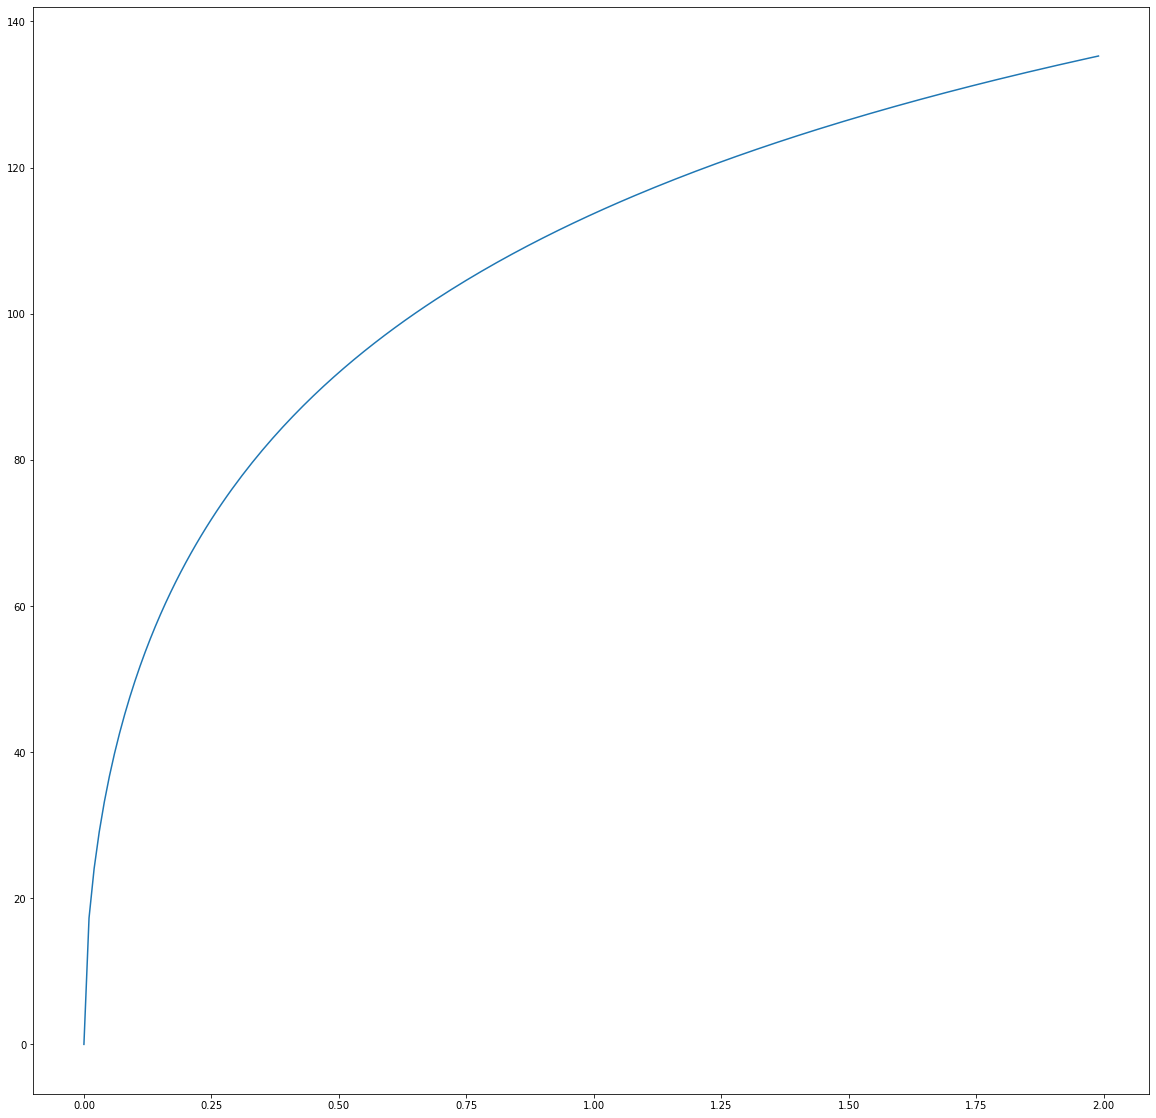

In [17]:
def get_rmax_ck22_augmented_arthur(Vmax, R17, fcor, Ck_Cd):
    '''Computes Rmax using CK22 model with the dependance on Ck_Cd
    INPUT: Vmax (m/s), R17 (m), fcor (s-1), Ck_Cd ()
    OUTPUT: Rmax (m)
    '''
    M17             = R17 * 17.5 + 0.5 * fcor * (R17 ** 2)
    Mmax_M17 = (0.5 * Ck_Cd) ** (1 / (2 - Ck_Cd))     # Eq. 38 of ER11. CAVEAT: We must have R17 >> Rmax
    Mmax          = Mmax_M17 * M17
    Rmax          = (Vmax / fcor) * (np.sqrt(1 + (2 * fcor * Mmax) / (Vmax ** 2)) - 1)
    return Rmax
x = arange(0, 2, 0.01)
Rmax_tmp = get_rmax_ck22_augmented_arthur(45 , 350 * 1000, 0.000085, x)
plot(x, Rmax_tmp/1000)